In [152]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
import os

In [90]:
work_dir = os.getcwd()
work_dir

'C:\\Users\\Evan\\Documents\\GitHub\\FuturesStrategy'

## Read the Data

In [126]:
Data_path = os.path.join(work_dir, 'Data')
TX = pd.read_csv(os.path.join(Data_path, 'TX.csv'), encoding = 'cp950')
OI = pd.read_csv(os.path.join(Data_path, 'MTXOpenInterest.csv'), encoding = 'cp950')
TX['日期'] = pd.to_datetime(TX['日期']) 
OI['日期'] = pd.to_datetime(OI['日期']) 

In [127]:
TX.shape

(4116, 8)

In [128]:
OI.shape

(735, 4)

In [129]:
OI.tail()

,日期,自營商,外資,投信
730,2020-04-16,1413602,1575209,42234
731,2020-04-17,2244324,-367902,42780
732,2020-04-20,1756390,-2425912,34568
733,2020-04-21,1538302,-2029498,33647
734,2020-04-22,914106,-2022450,32710


 Aggregating the open interest of Institutional investors

In [132]:
OI['三大法人總和'] = OI['自營商'] + OI['外資'] + OI['投信']

In [133]:
OI.tail()

,日期,自營商,外資,投信,三大法人總和
730,2020-04-16,1413602,1575209,42234,3031045
731,2020-04-17,2244324,-367902,42780,1919202
732,2020-04-20,1756390,-2425912,34568,-634954
733,2020-04-21,1538302,-2029498,33647,-457549
734,2020-04-22,914106,-2022450,32710,-1075634


## We take out the closest delivery TX as out underlying.  小台近日

In [134]:
TX00 = TX.drop_duplicates(subset = ['日期'], keep = 'first').reset_index(drop=True)

In [135]:
TX00.head()

,期貨名稱,日期,到期月,開盤價,收盤價,每日結算價,未平倉合約數,無風險利率
0,TX201705 台指 2017/05,2017-04-24,May-17,9747.0,9705.0,9706,86630,1.045
1,TX201705 台指 2017/05,2017-04-25,May-17,9746.0,9813.0,9814,88368,1.045
2,TX201705 台指 2017/05,2017-04-26,May-17,9855.0,9841.0,9842,88047,1.045
3,TX201705 台指 2017/05,2017-04-27,May-17,9829.0,9839.0,9838,88742,1.045
4,TX201705 台指 2017/05,2017-04-28,May-17,9847.0,9857.0,9856,88286,1.045


In [169]:
TX00['CC'] = TX00['每日結算價'].pct_change()
TX00['OC'] = (TX00['收盤價'] - TX00['開盤價'])/TX00['開盤價']

In [170]:
TX00.head()

,期貨名稱,日期,到期月,開盤價,收盤價,每日結算價,未平倉合約數,無風險利率,CC,OC
0,TX201705 台指 2017/05,2017-04-24,May-17,9747.0,9705.0,9706,86630,1.045,NaN,-0.004309
1,TX201705 台指 2017/05,2017-04-25,May-17,9746.0,9813.0,9814,88368,1.045,0.011127,0.006875
2,TX201705 台指 2017/05,2017-04-26,May-17,9855.0,9841.0,9842,88047,1.045,0.002853,-0.001421
3,TX201705 台指 2017/05,2017-04-27,May-17,9829.0,9839.0,9838,88742,1.045,-0.000406,0.001017
4,TX201705 台指 2017/05,2017-04-28,May-17,9847.0,9857.0,9856,88286,1.045,0.001830,0.001016


In [137]:
TX00.dtypes

期貨名稱              object
日期        datetime64[ns]
到期月               object
開盤價              float64
收盤價              float64
每日結算價              int64
未平倉合約數             int64
無風險利率            float64
dtype: object

## Show the TX first 

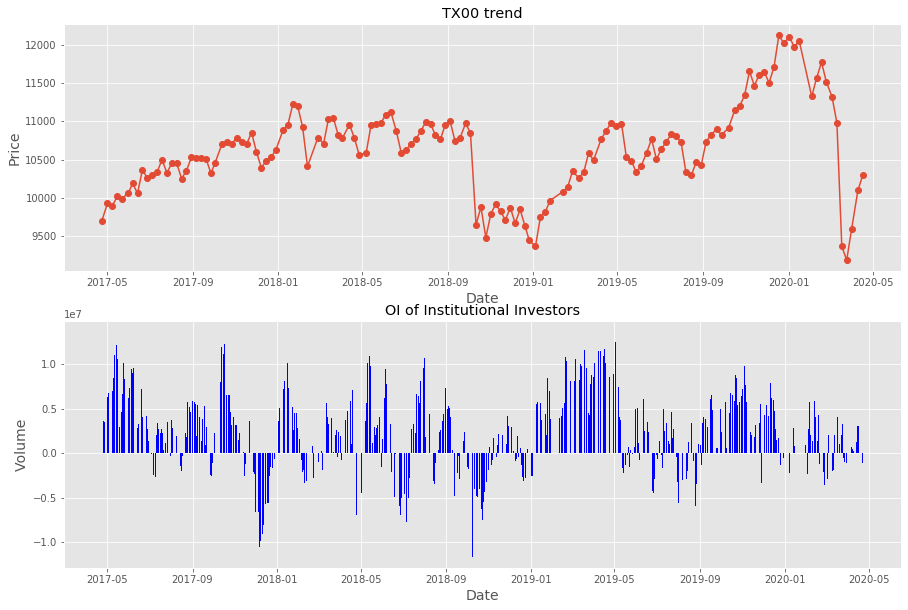

In [144]:
date = TX00.iloc[::5, :]['日期']
closePrice = TX00.iloc[::5, :]['每日結算價']
OIII = OI.iloc[:, :]['三大法人總和']
date1 = OI.iloc[:, :]['日期']

plt.style.use('ggplot')
plt.figure(figsize=(15,10))

plt.subplot(211)
plt.plot(date, closePrice, marker='o')
title_name1 = "TX00 trend" 
plt.title(title_name1)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Price', fontsize=14)

plt.subplot(212)
plt.bar(date1, OIII, color = 'blue')
title_name2 = "OI of Institutional Investors"
plt.title(title_name2)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Volume', fontsize=14)

plt.savefig(os.path.join(work_dir, 'Graph', title_name1 + title_name2))
plt.show()

## Run the correlation between MTXOI and TX

In [141]:
dailyMTXR = TX00['每日結算價'].pct_change()

In [142]:
dailyMTXR.head()

0         NaN
1    0.011127
2    0.002853
3   -0.000406
4    0.001830
Name: 每日結算價, dtype: float64

In [164]:
dailyOIchange = OI['三大法人總和'] - OI['三大法人總和'].shift(periods=1)

In [172]:
dailyOIchange.head()

0          NaN
1    3332060.0
2     -59445.0
3    -143837.0
4     589032.0
Name: 三大法人總和, dtype: float64

In [166]:
np.corrcoef(dailyMTXR[1:], dailyOIchange[1:])

array([[1.        , 0.46794229],
       [0.46794229, 1.        ]])

The correlation between the TX return and OIchange is 0.47

# Strategy Development 

* Buy and Hold
* Buy if the dailyOIchange is positive, Sell if the dailyOIchange is negative


In [ ]:
idx = (dailyOIchange)